In [1]:
!pip install transformers accelerate datasets scikit-learn pandas matplotlib -U -q
!pip install emoji

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv("finaldatasetfr.csv")

In [4]:
df.head()

,text,label
0,#Self_study if you want to be more creative li...,POS
1,ان دل على شئ انما يدل على شجاعة اهل السودان 💪,POS
2,طيب يا الي اغبى مني ،اقصد يا ناقص,NEG
3,لاوالله احبه واعشقه وودي فيه 😂,POS
4,الشطرنج♟️ لعبة مجوسية,NEG


In [5]:
counts = df["label"].value_counts()
percent = df["label"].value_counts(normalize=True) * 100
dist_df = pd.DataFrame({"Count": counts," percent %": percent})
print(dist_df)

         Count   percent %
label                     
POS      16233   38.980405
NEG      14416   34.617232
OBJ       8066   19.368937
NEUTRAL   2929    7.033426


In [6]:
df["char_length"]= df["text"].astype(str).apply(len)
print(df["char_length"].describe())

count    41644.000000
mean        91.037604
std        122.297625
min          1.000000
25%         38.000000
50%         75.000000
75%        113.000000
max       8109.000000
Name: char_length, dtype: float64


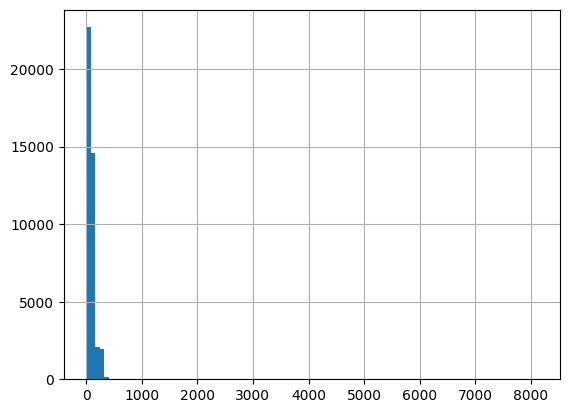

In [7]:
df["char_length"].hist(bins=100)
plt.show()


In [8]:
long_outliers=len(df[df["char_length"] > 400])

short_garbage=len(df[df["char_length"] <3])

print(f"Number of long outliers (>400 chars): {long_outliers}")
print(f"Number of short garbage (<3 chars): {short_garbage}")
df_clean=df[(df["char_length"] > 3) & (df["char_length"]<= 400)]
print(f"before cleaning",len(df))
df = df_clean
print(f"after cleaning",len(df))


Number of long outliers (>400 chars): 148
Number of short garbage (<3 chars): 3
before cleaning 41644
after cleaning 41486


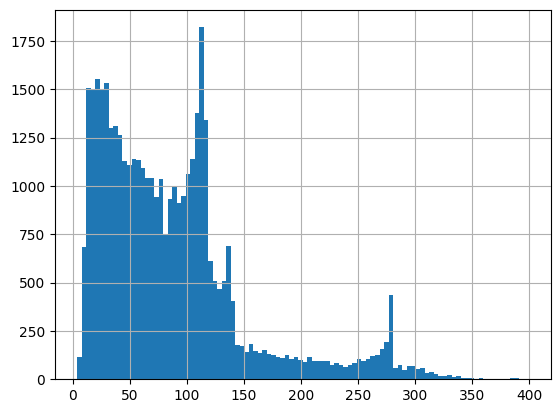

In [9]:
df["char_length"].hist(bins=100)
plt.show()


preprocessing pipeline

In [10]:
import aranorm
import re
import emoji

In [11]:
def final_pre_using_aranorm_and_another(text):
    text =re.sub(r"@\w+"," [مستخدم] ", text)

    text = re.sub(r"\d+"," [رقم] ", text)

    text = re.sub(r"[٠-٩]+", " [رقم] ", text)

    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    text = emoji.replace_emoji(text, replace='')


    text = re.sub(r"[a-zA-Z]+", "", text)
    text = re.sub(r'[#_]', ' ', text)

    text = aranorm.strip_tashkeel(text)

    text = aranorm.strip_tatweel(text)

    text = aranorm.normalize_lamalef(text)

    text = aranorm.normalize_hamza(text)

    # (ى->ي / ة->هـ)
    text = aranorm.normalize_spellerrors(text)

    text = re.sub(r"\s+", " ", text).strip()

    return text
#try
text = "يا @ahmed.. اللُغَة العَرَبِيّة جميـــــلة جداً!! هل قرأت الكِتَاب رقم 5؟ (ok)"

clean_text = final_pre_using_aranorm_and_another(text)

print(f"before: {text}")
print("------------------------------------------------")
print(f"after {clean_text}")

before: يا @ahmed.. اللُغَة العَرَبِيّة جميـــــلة جداً!! هل قرأت الكِتَاب رقم 5؟ (ok)
------------------------------------------------
after يا [مستخدم] .. اللغه العربيه جميله جدا!! هل قرات الكتاب رقم [رقم] ؟ ()


In [12]:
from tqdm import tqdm

In [13]:
tqdm.pandas()


column_name = "text"
df["cleaned_texto"] =df[column_name].progress_apply(final_pre_using_aranorm_and_another)


df.to_csv("cleaned___dataset.csv",index=False)

100%|██████████| 41486/41486 [00:23<00:00, 1794.57it/s]


In [14]:
df.head()

,text,label,char_length,cleaned_texto
0,#Self_study if you want to be more creative li...,POS,109,نصيحه قليل داءم خير من كثير منقطع ممكن تكون…
1,ان دل على شئ انما يدل على شجاعة اهل السودان 💪,POS,45,ان دل علي شء انما يدل علي شجاعه اهل السودان
2,طيب يا الي اغبى مني ،اقصد يا ناقص,NEG,34,طيب يا الي اغبي مني ،اقصد يا ناقص
3,لاوالله احبه واعشقه وودي فيه 😂,POS,30,لاوالله احبه واعشقه وودي فيه
4,الشطرنج♟️ لعبة مجوسية,NEG,21,الشطرنج لعبه مجوسيه


In [15]:
data =df[["cleaned_texto", "label"]].copy()

In [16]:
print("number of labels before normalize", data['label'].value_counts())

number of labels before normalize label
POS        16190
NEG        14316
OBJ         8054
NEUTRAL     2926
Name: count, dtype: int64


In [17]:
import numpy as np
rand_seed=0
np.random.seed(rand_seed)

In [18]:
min_class= data["label"].value_counts().min()
sampled_pos= data[data["label"] == "POS"].sample(n=min_class, random_state=rand_seed)
sampled_neg= data[data["label"] == "NEG"].sample(n=min_class, random_state=rand_seed)
sampled_obj= data[data["label"] == "OBJ"].sample(n=min_class, random_state=rand_seed)
sampled_neutral= data[data["label"] == "NEUTRAL"].sample(n=min_class, random_state=rand_seed)

balanced_data= pd.concat([sampled_pos, sampled_neg, sampled_obj, sampled_neutral])

balanced_data= balanced_data.sample(frac=1, random_state=rand_seed).reset_index(drop=True)

print(balanced_data["label"].value_counts())

label
OBJ        2926
NEG        2926
NEUTRAL    2926
POS        2926
Name: count, dtype: int64


NOW MODELS

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [20]:
def random_split(data, features, output, fraction, seed=0):
    X_train, X_test, y_train, y_test =train_test_split(
        data[features],
        data[output],
        train_size=fraction,
        random_state=seed,
        stratify=data[output]
    )
    train_data = pd.DataFrame({features: X_train, output:y_train})
    test_data = pd.DataFrame({features: X_test,output:y_test})

    return train_data, test_data
features ="cleaned_texto"
output ="label"

train_data,tmp_data=random_split(balanced_data, features, output, 0.90, rand_seed)

val_data, test_data = random_split(tmp_data, features, output, 0.50, rand_seed)

print(f"Training size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Testing size: {len(test_data)}")

Training size: 10533
Validation size: 585
Testing size: 586


In [21]:
vectorizer= TfidfVectorizer(ngram_range=(1,2),max_df=0.6,use_idf=True)

train_features= vectorizer.fit_transform(train_data[features])

val_features= vectorizer.transform(val_data[features])
test_features= vectorizer.transform(test_data[features])

y_train= train_data[output]

y_val= val_data[output]

y_test= test_data[output]

In [22]:
def train_n_test_classifier(clf, train_features, train_labels, test_features, test_labels):
    print(f"Training {clf.__class__.__name__} ")

    clf.fit(train_features, train_labels)

    score = clf.score(test_features,test_labels)

    print("Score on Validation data:")

    print(f"{score:.2%}")
    print("_" * 50)
    return score


classifiers =[LinearSVC(random_state=rand_seed),LogisticRegression(max_iter=1000, random_state=rand_seed),RandomForestClassifier(n_estimators=100, random_state=rand_seed),
MultinomialNB()
]
results = {}
for clf in classifiers:

    acc = train_n_test_classifier(clf, train_features, y_train, val_features, y_val)
    results[clf.__class__.__name__] = acc

print("\n final results:")
sorted_results = sorted(results.items(),key=lambda x:x[1], reverse=True)
for name, score in sorted_results:
    print(f"{name}: {score:.2%}")

Training LinearSVC 
Score on Validation data:
77.61%
__________________________________________________
Training LogisticRegression 
Score on Validation data:
75.56%
__________________________________________________
Training RandomForestClassifier 
Score on Validation data:
72.99%
__________________________________________________
Training MultinomialNB 
Score on Validation data:
73.85%
__________________________________________________

 final results:
LinearSVC: 77.61%
LogisticRegression: 75.56%
MultinomialNB: 73.85%
RandomForestClassifier: 72.99%


arabert

In [23]:
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np
from transformers import EarlyStoppingCallback;

min_class= data["label"].value_counts().min()
sampled_pos= data[data["label"] == "POS"].sample( n=min_class, random_state=0)
sampled_neg= data[data["label"] == "NEG"].sample( n=min_class, random_state=0)
sampled_obj= data[data["label"] == "OBJ"].sample( n=min_class, random_state=0)
sampled_neutral = data[data["label"] == "NEUTRAL"].sample(n=min_class, random_state=0)

balanced_data = pd.concat([sampled_pos, sampled_neg, sampled_obj, sampled_neutral])
balanced_data = balanced_data.sample(frac=1, random_state=0).reset_index(drop=True)

print("Balanced label counts:")
print(balanced_data["label"].value_counts())


print("\nDataFrame info:")
print(balanced_data.info())
print("\nFirst 5 rows:")
print(balanced_data.head())

print("\nUnique labels before mapping:")
print(balanced_data['label'].unique())

if pd.api.types.is_string_dtype(balanced_data["label"]):
    balanced_data['label'] = balanced_data['label'].str.strip()


balanced_data = balanced_data.dropna(subset=['label', 'cleaned_texto'])


label_map = {'POS': 0, 'NEG': 1, 'OBJ': 2, 'NEUTRAL': 3}
balanced_data['label'] = balanced_data['label'].map(label_map)


print("\nNaNs in label after mapping:", balanced_data['label'].isna().sum())
print("\nNumber of rows after additional cleaning:", len(balanced_data))
print("Unique labels after mapping:", balanced_data['label'].unique())


def random_split(data, features, output, fraction, seed=0):
    X_train, X_test, y_train, y_test = train_test_split(
        data[features],
        data[output],
        train_size=fraction,
        random_state=seed,
        stratify=data[output]
    )
    train_data = pd.DataFrame({features: X_train, output: y_train}).reset_index(drop=True)
    test_data = pd.DataFrame({features: X_test, output: y_test}).reset_index(drop=True)
    return train_data, test_data

features = "cleaned_texto"
output = "label"
rand_seed = 0

if features not in balanced_data.columns:
    raise ValueError(f"Error: No '{features}' column! Available: {balanced_data.columns}")

train_data, tmp_data = random_split(balanced_data, features, output, 0.90, rand_seed)
val_data, test_data = random_split(tmp_data, features, output, 0.50, rand_seed)

print(f"\nTraining size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Testing size: {len(test_data)}")

train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)


model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)


def preprocess_function(examples):
    return tokenizer(examples[features], truncation=True, padding="max_length", max_length=256)


tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    lr_scheduler_type="linear", # الأنواع المتاحة: linear, cosine, constant
    warmup_steps=100,           # خطوات تسخين للموديل في البداية
    # ---------------------------
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_strategy="epoch"
)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=1,
    early_stopping_threshold=0.0
))

trainer.train()


test_results = trainer.evaluate(tokenized_test)
print(f"Test Accuracy: {test_results["eval_accuracy"]:.2%}")

trainer.save_model("./arabert_finetuned_multi")
tokenizer.save_pretrained("./arabert_finetuned_multi")

Balanced label counts:
label
OBJ        2926
NEG        2926
NEUTRAL    2926
POS        2926
Name: count, dtype: int64

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11704 entries, 0 to 11703
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cleaned_texto  11704 non-null  object
 1   label          11704 non-null  object
dtypes: object(2)
memory usage: 183.0+ KB
None

First 5 rows:
                                       cleaned_texto    label
0             لقاءي في سي ان ان مع كريستيانا امانبور      OBJ
1                يرجال شايف اسمك ي الزنجي ي التكروني      NEG
2  هالكاتبه اذا ما استخدمه الخيال بمسلسلاتها تموت...  NEUTRAL
3  عاجل | مراسل الجزيره: اطلاق نار وتجدد الاشتباك...      OBJ
4                            الكتاب الاسود للتساءلات      OBJ

Unique labels before mapping:
['OBJ' 'NEG' 'NEUTRAL' 'POS']

NaNs in label after mapping: 0

Number of rows after additional cleaning: 11704
Unique l

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10533 [00:00<?, ? examples/s]

Map:   0%|          | 0/585 [00:00<?, ? examples/s]

Map:   0%|          | 0/586 [00:00<?, ? examples/s]

/tmp/ipython-input-1062277948.py:112: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy
1,0.848700,0.562801,0.793162
2,0.523700,0.516339,0.820513
3,0.372600,0.568814,0.825641


Test Accuracy: 82.08%


('./arabert_finetuned_multi/tokenizer_config.json',
 './arabert_finetuned_multi/special_tokens_map.json',
 './arabert_finetuned_multi/vocab.txt',
 './arabert_finetuned_multi/added_tokens.json',
 './arabert_finetuned_multi/tokenizer.json')

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

saved_path = "./arabert_finetuned_multi"
tokenizer = AutoTokenizer.from_pretrained(saved_path)
model = AutoModelForSequenceClassification.from_pretrained(saved_path)

text ="عاجل | مراسل #الجزيرة: قوات الاحتلال الإسرائيلي تطلق قنابل مضيئة في سماء قرية المشيرفة بريف القنيطرة"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=400)

with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

label_map = {0: 'POS', 1: 'NEG', 2: 'OBJ', 3: 'NEUTRAL'}
predicted_label = label_map[predictions.item()]

print(f"sentence {text}")
print(f"expected pred: {predicted_label}")

sentence عاجل | مراسل #الجزيرة: قوات الاحتلال الإسرائيلي تطلق قنابل مضيئة في سماء قرية المشيرفة بريف القنيطرة
expected pred: OBJ


**Now its time to build the best model**

In [25]:
df_z3=pd.read_csv("cleaned___dataset.csv")
df_z3["label"] = df_z3["label"].replace("NEUTRAL","OBJ")

In [26]:
df_z3=df_z3[df_z3["label"].isin(["POS","NEG","OBJ"])]

df_z3=df_z3.dropna(subset=["label","cleaned_texto"])
print(df_z3["label"].value_counts())

label
POS    16190
NEG    14316
OBJ    10980
Name: count, dtype: int64


In [27]:
min_count=df_z3["label"].value_counts().min()
print(min_count)

10980


In [28]:
df_pos=df_z3[df_z3["label"]=="POS"].sample(n=min_count,random_state=rand_seed)
df_neg=df_z3[df_z3["label"]=="NEG"].sample(n=min_count,random_state=rand_seed)
df_obj=df_z3[df_z3["label"]=="OBJ"].sample(n=min_count,random_state=rand_seed)

THEbalanced_data = pd.concat([df_pos, df_neg, df_obj])
THEbalanced_data = THEbalanced_data.sample(frac=1, random_state=rand_seed).reset_index(drop=True)

In [29]:
print("labels before mapping:",THEbalanced_data["label"].unique())

labels before mapping: ['OBJ' 'POS' 'NEG']


In [30]:
if THEbalanced_data["label"].dtype == "object":
    label_map = {"POS": 0, "NEG": 1, "OBJ": 2}
    THEbalanced_data["label"] = THEbalanced_data["label"].map(label_map)
else:
    print("ERROrr")

In [31]:
print("labels after mapping:",THEbalanced_data["label"].unique())
print(f"{len(THEbalanced_data)}")

labels after mapping: [2 0 1]
32940


In [32]:
features = "cleaned_texto"
output = "label"

In [33]:
def random_split(data, features, output, fraction, seed=0):
    X_train, X_test, y_train, y_test = train_test_split(
        data[features],
        data[output],
        train_size=fraction,
        random_state=seed,
        stratify=data[output]
    )

    train_data= pd.DataFrame({features:X_train,output:y_train}).reset_index(drop=True)
    test_data =pd.DataFrame({features:X_test,output:y_test}).reset_index(drop=True)
    return train_data, test_data

In [34]:
train_data, tmp_data = random_split(THEbalanced_data, features, output, 0.90, rand_seed)

val_data, test_data = random_split(tmp_data, features, output, 0.50, rand_seed)

print(f"training: {len(train_data)} __ validation: {len(val_data)} __ testing: {len(test_data)}")

training: 29646 __ validation: 1647 __ testing: 1647


ML

In [35]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.6, use_idf=True)

train_features = vectorizer.fit_transform(train_data[features])

val_features = vectorizer.transform(val_data[features])

test_features = vectorizer.transform(test_data[features])

y_train = train_data[output]

y_val = val_data[output]

y_test = test_data[output]
print("features dimensions:")
print(f"train: {train_features.shape}")
print(f"val:   {val_features.shape}")
print(f"test:  {test_features.shape}")

features dimensions:
train: (29646, 402177)
val:   (1647, 402177)
test:  (1647, 402177)


In [36]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

results = {}


svm_model= LinearSVC(random_state=rand_seed)

svm_model.fit(train_features, y_train)

svm_score= svm_model.score(val_features,y_val)
print(f"svm score on validation data: {svm_score:.2%}")
print("_"*50)

results["LinearSVC"]= svm_score


lr_model = LogisticRegression(max_iter=1000,random_state=rand_seed)
lr_model.fit(train_features, y_train)

lr_score = lr_model.score(val_features, y_val)
print(f"log r score on validation data: {lr_score:.2%}")
print("_"*50)

results["LogisticRegression"] = lr_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=rand_seed)

rf_model.fit(train_features, y_train)

rf_score = rf_model.score(val_features, y_val)

print(f" random forest score on validation data: {rf_score:.2%}")
print("_"*50)

results["RandomForest"]= rf_score


nb_model = MultinomialNB()
nb_model.fit(train_features, y_train)

nb_score = nb_model.score(val_features, y_val)
print(f" multinb score on validation data: {nb_score:.2%}")
print("_" * 50)

results["MultinomialNB"] = nb_score

print("final Results :")
sorted_results=sorted(results.items(),key=lambda x: x[1],reverse=True)

for name, score in sorted_results:
    print(f"{name}: {score:.2%}")

svm score on validation data: 84.76%
__________________________________________________
log r score on validation data: 81.42%
__________________________________________________
 random forest score on validation data: 81.12%
__________________________________________________
 multinb score on validation data: 80.15%
__________________________________________________
final Results :
LinearSVC: 84.76%
LogisticRegression: 81.42%
RandomForest: 81.12%
MultinomialNB: 80.15%


In [39]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(train_features, y_train)
dummy_preds = dummy.predict(test_features)
dummy_acc = accuracy_score(y_test, dummy_preds)

print("="*50)
print("BASELINE MODEL (Majority Class)")
print("="*50)
print(f"Majority Baseline Accuracy: {dummy_acc:.2%}")
print(f"This is the minimum acceptable performance - any model must beat it!")
print("="*50)

BASELINE MODEL (Majority Class)
Majority Baseline Accuracy: 33.33%
This is the minimum acceptable performance - any model must beat it!


In [40]:
print("preparing Data")
df_train=train_data[["cleaned_texto","label"]].rename(columns={"cleaned_texto": "text"})
df_val =val_data[["cleaned_texto", "label"]].rename(columns={"cleaned_texto": "text"})
df_test=test_data[["cleaned_texto","label"]].rename(columns={"cleaned_texto": "text"})

dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

model_name="aubmindlab/bert-base-arabertv02"

tokenizer= AutoTokenizer.from_pretrained(model_name)
model= AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing")
tokenized_train= dataset_train.map(tokenize_function, batched=True)
tokenized_val= dataset_val.map(tokenize_function, batched=True)
tokenized_test= dataset_test.map(tokenize_function, batched=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

training_args = TrainingArguments(
    output_dir="./arabert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    warmup_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)


trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=1,
    early_stopping_threshold=0.0
))

print("Starting Training")
trainer.train()

print("Evaluating on Test Data")
test_results = trainer.predict(tokenized_test)
final_acc = test_results.metrics['test_accuracy']

print("\n" + "="*40)
print(f"AraBERT Final Accuracy: {final_acc:.2%}")
print("="*40)

results["AraBERT"] = final_acc

preparing Data


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing


Map:   0%|          | 0/29646 [00:00<?, ? examples/s]

Map:   0%|          | 0/1647 [00:00<?, ? examples/s]

Map:   0%|          | 0/1647 [00:00<?, ? examples/s]

Starting Training


Epoch,Training Loss,Validation Loss,Accuracy
1,0.380800,0.312508,0.880389
2,0.249600,0.309686,0.896782
3,0.181100,0.373988,0.888282


Evaluating on Test Data



AraBERT Final Accuracy: 88.04%


In [49]:
from sklearn.metrics import confusion_matrix

arabert_predictions = np.argmax(test_results.predictions, axis=-1)
arabert_true_labels = test_results.label_ids
cm_arabert = confusion_matrix(arabert_true_labels, arabert_predictions)


print("="*60)
print("ERROR ANALYSIS - AraBERT")
print("="*60)


arabert_errors_idx = np.where(arabert_predictions != arabert_true_labels)[0]
print(f"\n Total Errors: {len(arabert_errors_idx)} out of {len(arabert_true_labels)} ({len(arabert_errors_idx)/len(arabert_true_labels)*100:.2f}%)")


print("\n Most Common Error Patterns:")
print("-"*60)

cm_arabert_copy = cm_arabert.copy()
np.fill_diagonal(cm_arabert_copy, 0)

arabert_error_pairs = []
arabert_class_names = ["POS", "NEG", "OBJ"]
for i in range(3):
    for j in range(3):
        if i != j and cm_arabert_copy[i, j] > 0:
            arabert_error_pairs.append((arabert_class_names[i], arabert_class_names[j], cm_arabert_copy[i, j]))

arabert_error_pairs.sort(key=lambda x: x[2], reverse=True)

for true_label, pred_label, count in arabert_error_pairs[:5]:
    print(f"   {true_label} misclassified as {pred_label}: {count} times")

print("\n Error Examples:")
print("-"*60)

arabert_label_names = {0: "POS", 1: "NEG", 2: "OBJ"}

for idx in arabert_errors_idx[:5]:
    true_lbl = arabert_label_names[arabert_true_labels[idx]]
    pred_lbl = arabert_label_names[arabert_predictions[idx]]
    text = df_test.iloc[idx]['text']

    print(f"True: {true_lbl} | Predicted: {pred_lbl}")
    print(f"   Text: {text[:100]}..." if len(text) > 100 else f"   Text: {text}")
    print()

ERROR ANALYSIS - AraBERT

 Total Errors: 197 out of 1647 (11.96%)

 Most Common Error Patterns:
------------------------------------------------------------
   POS misclassified as OBJ: 56 times
   OBJ misclassified as POS: 46 times
   NEG misclassified as OBJ: 37 times
   OBJ misclassified as NEG: 31 times
   POS misclassified as NEG: 17 times

 Error Examples:
------------------------------------------------------------
True: OBJ | Predicted: POS
   Text: ياجمالهم منظرهم طبيعي ومن اول المقطع وانا مبتسمه اكاد ابكي .. خساره راحت علينا احنا واصبنا بالاكتءاب...

True: NEG | Predicted: OBJ
   Text: الطرق السلميه والمتحضره هي في ظننا احد سبل النضال السلمي والمشروع للضغط علي الحكومات في المنطقه لتنه...

True: POS | Predicted: OBJ
   Text: وانتم مثل يسرا كل يوم مع فنان مره سيدني ومره لخويا ومره العين ومره عادل امام

True: POS | Predicted: OBJ
   Text: دعوه للتفاءل الحياه بتفاءل و امل

True: OBJ | Predicted: NEG
   Text: تخللوا انتم وواقعكم~ نوبه جنون



FULL EVALUATION - AraBERT (Best Deep Learning Model)

 Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

         POS     0.8947    0.8670    0.8807       549
         NEG     0.9127    0.9144    0.9136       549
         OBJ     0.8354    0.8597    0.8474       549

    accuracy                         0.8804      1647
   macro avg     0.8810    0.8804    0.8805      1647
weighted avg     0.8810    0.8804    0.8805      1647


 Confusion Matrix:
[[476  17  56]
 [ 10 502  37]
 [ 46  31 472]]


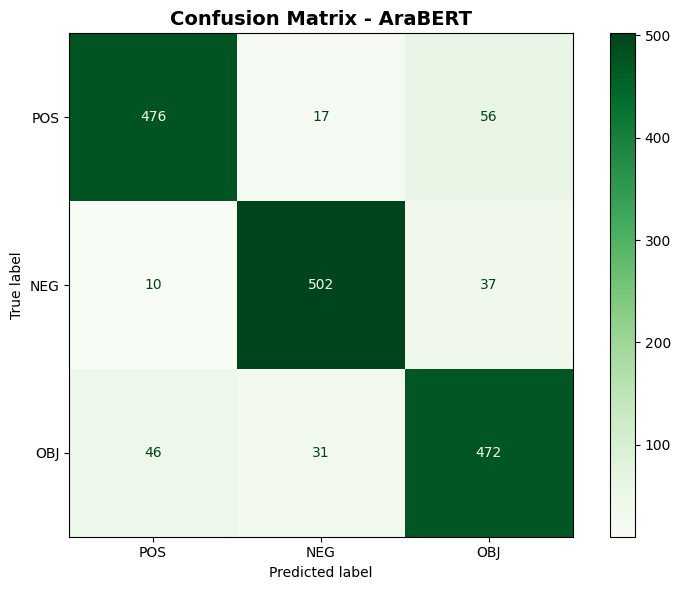


 Summary Metrics (Weighted Average):
   Precision: 0.8810
   Recall:    0.8804
   F1-Score:  0.8805


In [50]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("="*60)
print("FULL EVALUATION - AraBERT (Best Deep Learning Model)")
print("="*60)

arabert_predictions = np.argmax(test_results.predictions, axis=-1)
arabert_true_labels = test_results.label_ids

print("\n Classification Report:")
print("-"*60)
print(classification_report(arabert_true_labels, arabert_predictions,
                           target_names=["POS", "NEG", "OBJ"], digits=4))

print("\n Confusion Matrix:")
cm_arabert = confusion_matrix(arabert_true_labels, arabert_predictions)
print(cm_arabert)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_arabert, display_labels=["POS", "NEG", "OBJ"])
disp.plot(ax=ax, cmap='Greens', values_format='d')
plt.title("Confusion Matrix - AraBERT", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

precision = precision_score(arabert_true_labels, arabert_predictions, average='weighted')
recall = recall_score(arabert_true_labels, arabert_predictions, average='weighted')
f1 = f1_score(arabert_true_labels, arabert_predictions, average='weighted')

print("\n Summary Metrics (Weighted Average):")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

FINAL MODELS COMPARISON
 Rank              Model Accuracy
    1            AraBERT   88.04%
    2          LinearSVC   84.76%
    3 LogisticRegression   81.42%
    4       RandomForest   81.12%
    5      MultinomialNB   80.15%
    6  Majority Baseline   33.33%


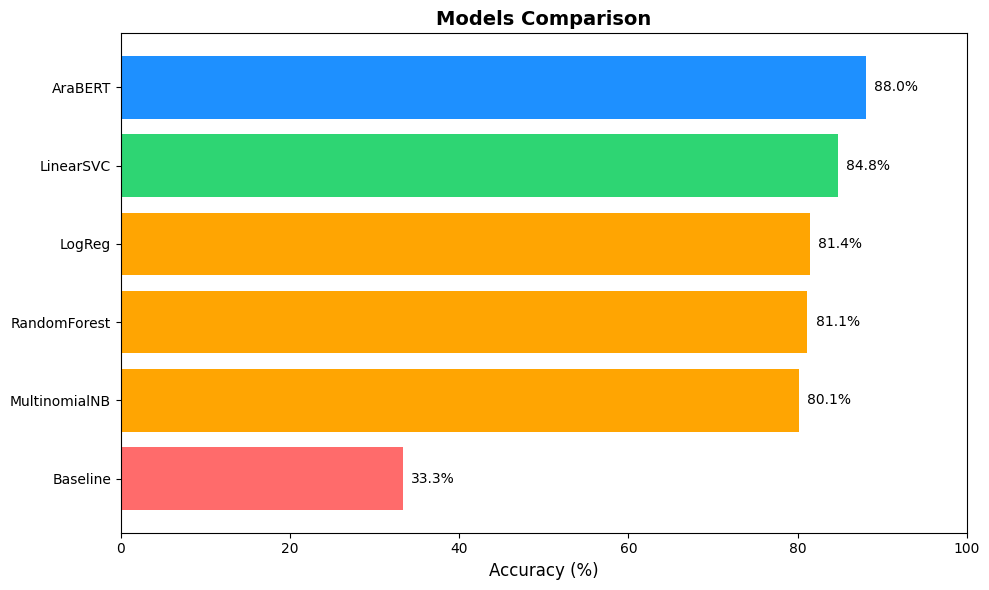

In [54]:
print("="*70)
print("FINAL MODELS COMPARISON")
print("="*70)

comparison_data = {
    "Model": ["Majority Baseline", "LinearSVC", "LogisticRegression", "RandomForest", "MultinomialNB", "AraBERT"],
    "Accuracy": [
        dummy_acc,
        svm_score,
        lr_score,
        rf_score,
        nb_score,
        final_acc
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values("Accuracy", ascending=False).reset_index(drop=True)
comparison_df["Accuracy"] = comparison_df["Accuracy"].apply(lambda x: f"{x:.2%}")
comparison_df["Rank"] = range(1, len(comparison_df) + 1)
comparison_df = comparison_df[["Rank", "Model", "Accuracy"]]

print(comparison_df.to_string(index=False))



fig, ax = plt.subplots(figsize=(10, 6))
models = ["Baseline", "MultinomialNB", "RandomForest", "LogReg", "LinearSVC", "AraBERT"]
accuracies = [dummy_acc, nb_score, rf_score, lr_score, svm_score, final_acc]
colors = ['#ff6b6b', '#ffa502', '#ffa502', '#ffa502', '#2ed573', '#1e90ff']

bars = ax.barh(models, [acc * 100 for acc in accuracies], color=colors)
ax.set_xlabel('Accuracy (%)', fontsize=12)
ax.set_title('Models Comparison', fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)

for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{acc:.1%}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [52]:
# ---------------------------------------------------------
# 6. حفظ الموديل النهائي والتوكنايزر
# ---------------------------------------------------------

print("Saving the final model and tokenizer...")

# حفظ الموديل والتوكنايزر في مجلد واحد
save_directory = "./arabert_finetuned_3class_final"  # غيّر الاسم زي ما تحب

trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"model saved in folder :  {save_directory}")


# اختبار سريع عشان تتأكد إن الحفظ صح (اختياري)
print("\n model test saved ")
test_tokenizer = AutoTokenizer.from_pretrained(save_directory)
test_model = AutoModelForSequenceClassification.from_pretrained(save_directory)

print("done")

Saving the final model and tokenizer...
model saved in folder :  ./arabert_finetuned_3class_final

 model test saved 
done


In [53]:
# ---------------------------------------------------------
# 7. تحميل الموديل مباشرة على Google Drive (بدون تحميل على الجهاز)
# ---------------------------------------------------------

from google.colab import drive
import shutil   # ← أضف السطر ده هنا

# ربط الكولاب بـ Google Drive بتاعك (هيطلب منك إذن مرة واحدة)
drive.mount('/content/drive')

# المجلد اللي حفظت فيه الموديل
model_folder = "./arabert_finetuned_3class_final"  # غيّر الاسم لو مختلف

# عمل zip للموديل
zip_filename = "arabert_sentiment_model.zip"
shutil.make_archive("arabert_sentiment_model", 'zip', model_folder)

print(f"تم عمل zip للموديل: {zip_filename}")

# انسخ الـ zip للدرايف
drive_path = "/content/drive/MyDrive/"  # أو مجلد داخل الدرايف زي "/content/drive/MyDrive/Models/"
shutil.copy(zip_filename, drive_path)

print(f"تم نسخ الـ zip بنجاح إلى Google Drive في: {drive_path}")
print("دلوقتي الموديل موجود على الدرايف بتاعك، وتقدر تحمله من أي مكان!")

Mounted at /content/drive
تم عمل zip للموديل: arabert_sentiment_model.zip
تم نسخ الـ zip بنجاح إلى Google Drive في: /content/drive/MyDrive/
دلوقتي الموديل موجود على الدرايف بتاعك، وتقدر تحمله من أي مكان!
